In [16]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import importlib
import scripts.project_utils.deciles as deciles
import scripts.project_utils.binary_classification as bc
import scripts.general_utils.LDI_VIF as LV
from scripts.general_utils import utils
from scripts.general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot

# Reload necessary modules
importlib.reload(bc)

# Apply default settings
utils.default_plot_format()
utils.pd_display_settings(3)

In [17]:
#data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"
data_path = r"results\processed_10min_04_15.pkl"

In [18]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
1627,20405,21605,41.26,47.90,31.43,76.36,3.41e-09,0.0025,2.41e-06,1.31e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
1628,21606,22806,37.65,29.76,8.08,78.62,1.62e-09,0.0025,1.54e-06,2.77e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
1629,22806,24006,41.37,20.94,2.06,82.40,2.78e-08,0.0025,3.78e-05,4.39e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
1630,80425,81625,11.32,5.31,0,82.25,1.85e-08,0.00167,1.39e-05,2.86e-06,...,8.77,1.52,1,0,0,True,1,0,0,DPN
1631,75689,76888,160.83,211.30,28.49,76.05,1.15e-09,0.0025,1.21e-06,3.9e-07,...,10.23,0.43,1,0,0,True,0,0,1,DPN


In [19]:
median_melted = deciles.produce_median_melt(data, indicator_columns)
median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()

Predictions: [False False False False False False False False False False False False
 False False False False False False False False False False False  True
  True False]
              precision    recall  f1-score   support

       False       0.92      1.00      0.96        22
        True       1.00      0.50      0.67         4

    accuracy                           0.92        26
   macro avg       0.96      0.75      0.81        26
weighted avg       0.93      0.92      0.91        26

Accuracy: 0.9230769230769231


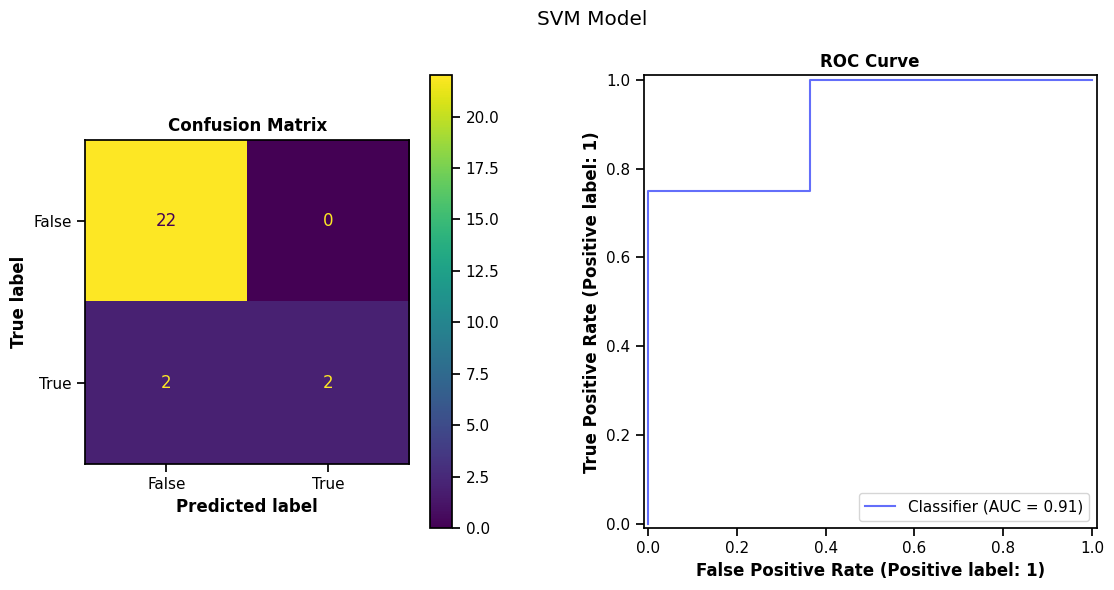

In [20]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
importlib.reload(bc)

def build_svm(data, columns = None, kernel='linear'):
    y = median_pivot["DPN"]
    X = data.drop(columns=["id", "DPN"])  # Features
    if columns:
        X = X[columns]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Build and train the SVM model
    svm_model = SVC(kernel=kernel, random_state=42)
    svm_model.fit(X_scaled, y)
    return svm_model, X_scaled, y


def plot_cvm_result(svm_model, X_scaled, y,  title="SVM Model"):
    
    y_pred = svm_model.predict(X_scaled)
    print("Predictions:", y_pred)
    print(classification_report(y, y_pred))
    print("Accuracy:", accuracy_score(y, y_pred))
    res = {
            'confusion_matrix': bc.confusion_matrix(y, y_pred),
            'y_pred_proba': svm_model.decision_function(X_scaled)
        }


    # Call the function to plot evaluation metrics
    bc.plot_evaluation_metrics(res, y, title=title)

plot_cvm_result(*build_svm(median_pivot))

In [21]:

vif_median = median_pivot.copy()


def automatic_vif_reduction(data, keep_n=5):
    data=data.copy()
    removed_features = []
    for _ in range(len(data.columns) - 2 - keep_n):
        vif_data = LV.get_vif(data.drop(columns=['id', 'DPN']))
        max_vif_value = vif_data["Full VIF"].max()

        max_vif_col = vif_data.loc[vif_data["Full VIF"] == max_vif_value, "feature"].iloc[0]
        data = data.drop(columns=[max_vif_col])
        removed_features.append(max_vif_col)
    print(f"Removed: {removed_features}")
    return data, removed_features


def plot_vif_reduction(vif_median, removed_features):
    remaining_features = [col for col in vif_median.columns if col not in removed_features + ['id', 'DPN']]
    print(f"Remaining features: {remaining_features}")
    lda_df, lda = LV.perform_lda(vif_median, remaining_features)
    LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
    LV.show_linear_lda_stats(lda, remaining_features)
    LV.plot_vif(LV.get_vif(vif_median.drop(columns=['id', 'DPN'])))

#vif_median, removed_features = automatic_vif_reduction(median_pivot.copy())
#plot_vif_reduction(vif_median, removed_features)


Removed: ['RMSSD', 'SDRR', 'DFA α1', 'ApEn', 'SD1', 'VLF Peak Frequency', 'Mean HR (bpm)', 'HF Peak Frequency', 'SD2', 'LF÷HF Ratio', 'LF Peak Frequency', 'D2', 'DFA α2', 'SD1÷SD2']

 columns left: Index(['id', 'DPN', 'HF Power', 'LF Power', 'S', 'SampEn', 'VLF Power',
       'pNN50 (%)'],
      dtype='object', name='metric')
Predictions: [False False False False False False False False False False False  True
 False False False False False False False False False False False  True
  True False]
              precision    recall  f1-score   support

       False       0.91      0.95      0.93        22
        True       0.67      0.50      0.57         4

    accuracy                           0.88        26
   macro avg       0.79      0.73      0.75        26
weighted avg       0.88      0.88      0.88        26

Accuracy: 0.8846153846153846


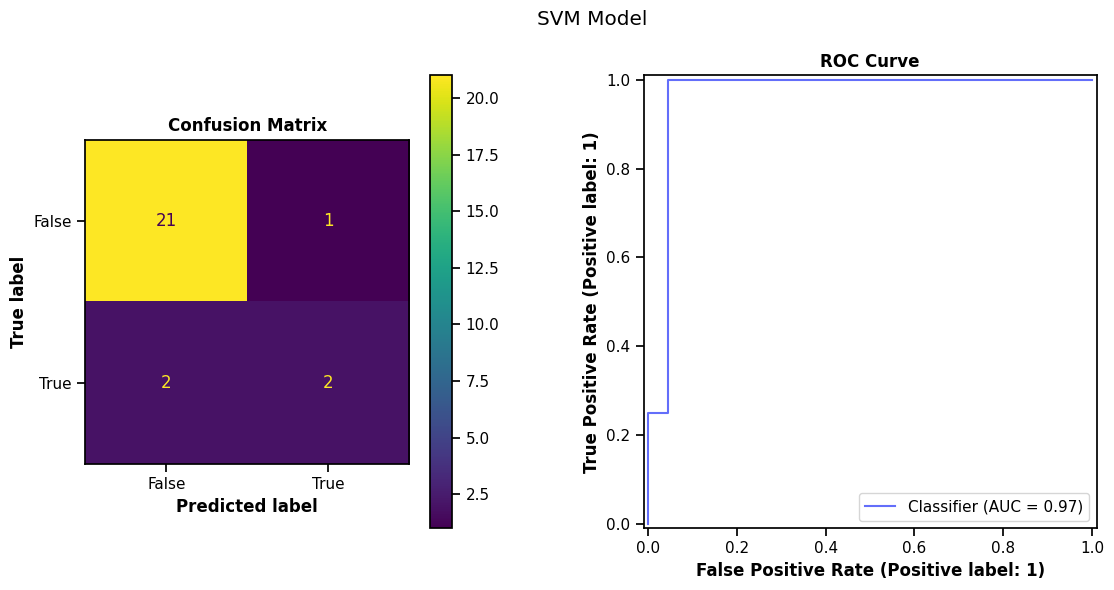

Remaining features: ['HF Power', 'LF Power', 'S', 'SampEn', 'VLF Power', 'pNN50 (%)']


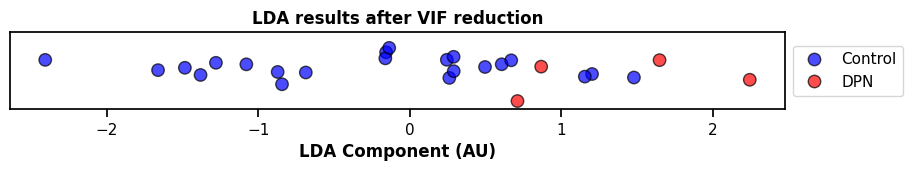

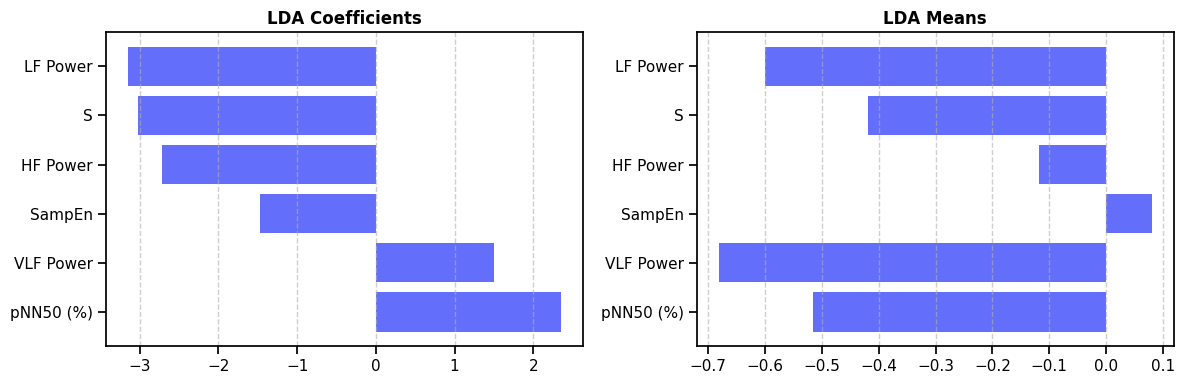

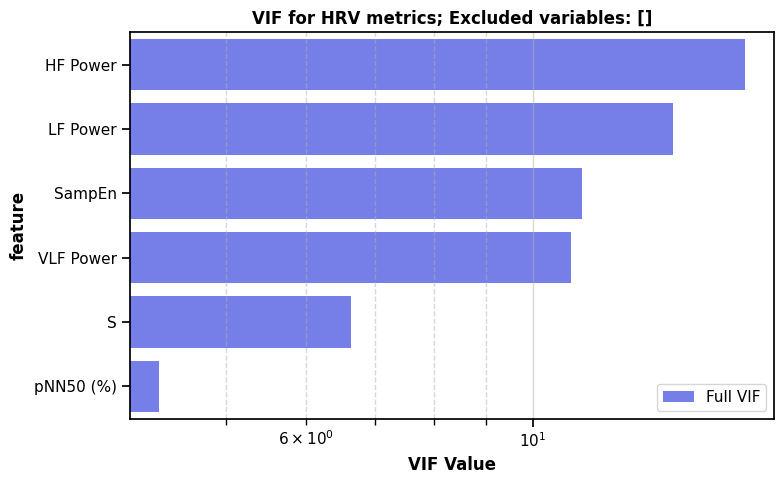

In [22]:

vif_median, removed_features = automatic_vif_reduction(median_pivot, 6)
print("\n columns left:",vif_median.columns)
plot_cvm_result(*build_svm(vif_median))
plot_vif_reduction(vif_median, removed_features)

## Recursive SVM feature reduction

In [23]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

Optimal number of features: 1
Selected features: Index(['ApEn'], dtype='object', name='metric')

# Linear SVM with feature selection

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
import warnings
from sklearn.feature_selection import SequentialFeatureSelector

Selected 3 features: ['D2', 'DFA α1', 'DFA α2']
Predictions: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
              precision    recall  f1-score   support

       False       0.85      1.00      0.92        22
        True       0.00      0.00      0.00         4

    accuracy                           0.85        26
   macro avg       0.42      0.50      0.46        26
weighted avg       0.72      0.85      0.78        26

Accuracy: 0.8461538461538461


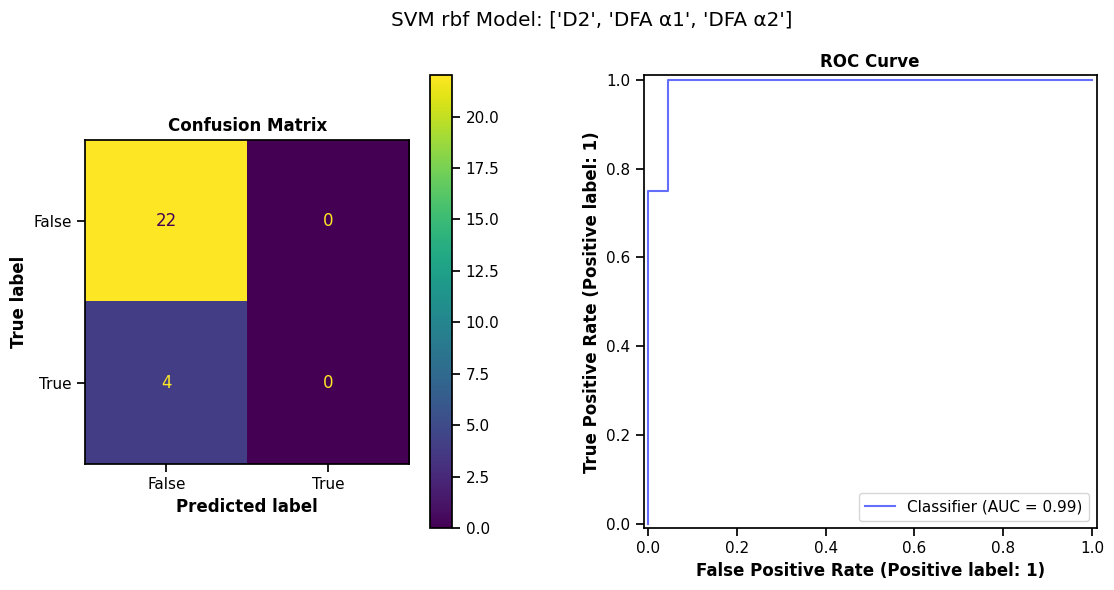

In [25]:


warnings.filterwarnings('ignore')
n= 3
data = median_pivot.copy()
data =data.drop(columns=['ApEn'])

y = data["DPN"]  # Target
X = data.drop(columns=["id", "DPN"])  # Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

estimator = SVC(kernel='rbf', random_state=42)
estimator.fit(X_scaled, y)

sfs = SequentialFeatureSelector(estimator, n_features_to_select=n, direction="forward", scoring='precision', cv=5)
sfs.fit(X_scaled, y)
selected_features = X.columns[sfs.get_support()].tolist()

print(f"Selected {len(selected_features)} features:", selected_features)

#Radial basis
plot_cvm_result(*build_svm(data, selected_features,'rbf'), title=f"SVM rbf Model: {selected_features}")

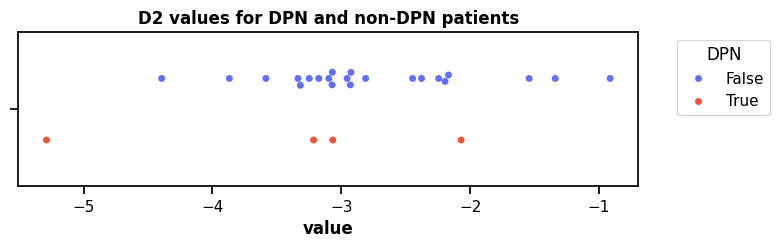

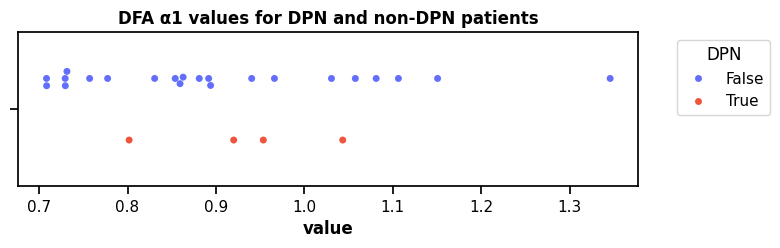

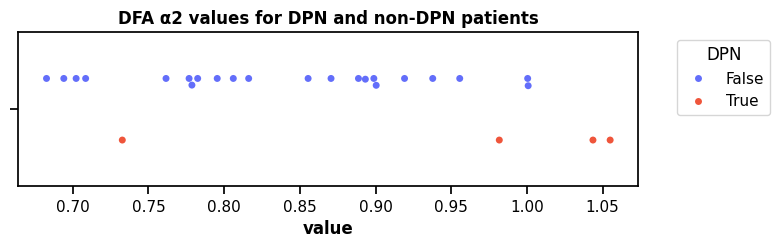

In [26]:
for feature in selected_features:
    plt.figure(figsize=(8, 2))
    sns.swarmplot(
        data=median_melted[median_melted['metric'] == feature],
        hue='DPN',
        x='value',
        dodge=True
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='DPN')
    plt.title(f'{feature} values for DPN and non-DPN patients')
    plt.show()

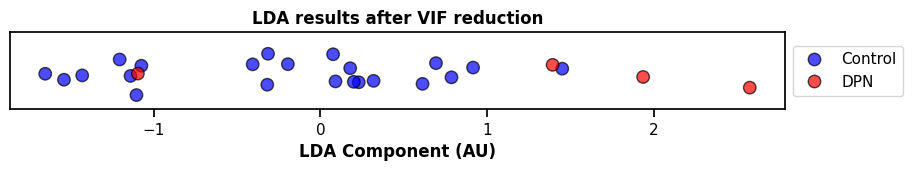

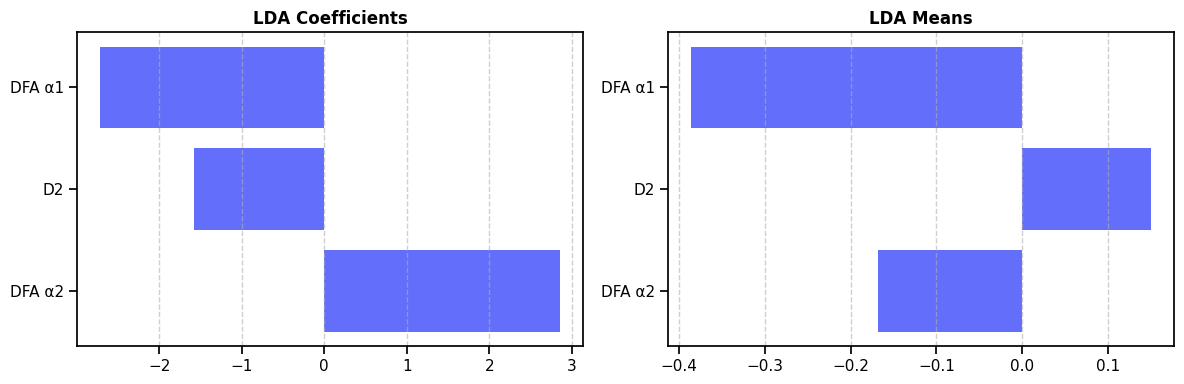

,Columns,LDA Coef,Means
0,D2,-1.58,0.15
1,DFA α1,-2.71,-0.39
2,DFA α2,2.86,-0.17


In [27]:

lda_df, lda = LV.perform_lda(median_pivot, selected_features)
LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
LV.show_linear_lda_stats(lda, selected_features)

#